In [1]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr, ttest_ind, mannwhitneyu, wilcoxon, levene
from itertools import combinations
from statannotations.Annotator import Annotator

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

# Linear Regression Models Predicting Handcrafted Features

In [2]:
# Load configuration
with open("../../config/config_notebooks_TNBC.json", "r") as config_file:
    config = json.load(config_file)
    
a = config["base_color_palette"]
sns.set_palette(a)
base_model_palette = config["base_model_palette"]
base_models = config["base_model_list"]
path_to_regression_results = os.path.join(config["base_benchmark_folder"], "regression", "linear")

In [3]:
dfs = []
for file in base_models:
    dfs.append(pd.read_csv(os.path.join(path_to_regression_results, file, 'r2_scores.csv'), index_col=0))
df = pd.concat(dfs, axis=1)
df.columns = base_models
df.drop([idx for idx in df.index if idx.startswith('ExtraCell-Morph')], inplace=True)
df[df < 0] = 0
df['feature_type'] = [idx.split('_')[0] for idx in df.index]

In [4]:
for feature_type in df['feature_type'].unique():
    print(f"############## {feature_type} ##############")
    for f in df[df['feature_type'] == feature_type].index:
        print('_'.join(f.split('_')[1:]))

############## Nuclei-Morph ##############
Area_mean
AreaBbox_mean
CellEccentricities_mean
Circularity_mean
Elongation_mean
Extent_mean
MajorAxisLength_mean
MinorAxisLength_mean
Perimeter_mean
Solidity_mean
CurvMean_mean
CurvStd_mean
CurvMax_mean
CurvMin_mean
Area_std
AreaBbox_std
CellEccentricities_std
Circularity_std
Elongation_std
Extent_std
MajorAxisLength_std
MinorAxisLength_std
Perimeter_std
Solidity_std
CurvMean_std
CurvStd_std
CurvMax_std
CurvMin_std
############## Nuclei-Texture ##############
ASM_mean
Contrast_mean
Correlation_mean
Dissimilarity_mean
Entropy_mean
Homogeneity_mean
IntensityMean_mean
IntensityStd_mean
ASM_std
Contrast_std
Correlation_std
Dissimilarity_std
Entropy_std
Homogeneity_std
IntensityMean_std
IntensityStd_std
############## Nuclei-Color ##############
MeanColor_R_mean
MeanColor_G_mean
MeanColor_B_mean
MeanTransparency_mean
StdColor_R_mean
StdColor_G_mean
StdColor_B_mean
StdTransparency_mean
SkewColor_R_mean
SkewColor_G_mean
SkewColor_B_mean
KurtosisColo

In [5]:
df.loc[[idx for idx in df.index if idx.startswith('Nuclei-Composition')]]

,uni,uni2,virchow,provgigapath,ctranspath,simclr,feature_type
Nuclei-Composition_number_of_cells,0.927417,0.926161,0.933268,0.935047,0.896544,0.936554,Nuclei-Composition
Nuclei-Composition_total_cell_density,0.927455,0.926156,0.933328,0.935044,0.896560,0.936593,Nuclei-Composition
Nuclei-Composition_prop_of_T_cells,0.482198,0.488614,0.475231,0.492814,0.452092,0.478152,Nuclei-Composition
Nuclei-Composition_density_of_T_cells,0.523601,0.534824,0.541101,0.551285,0.546735,0.538325,Nuclei-Composition
Nuclei-Composition_prop_of_I_cells,0.530224,0.521477,0.512884,0.521810,0.422790,0.525142,Nuclei-Composition
Nuclei-Composition_density_of_I_cells,0.715746,0.710231,0.716732,0.722411,0.621886,0.716319,Nuclei-Composition
Nuclei-Composition_prop_of_S_cells,0.698277,0.697381,0.681217,0.685497,0.617282,0.687649,Nuclei-Composition
Nuclei-Composition_density_of_S_cells,0.735072,0.730120,0.742471,0.734726,0.681546,0.740581,Nuclei-Composition
Nuclei-Composition_prop_of_N_cells,0.514854,0.516417,0.511150,0.530714,0.457401,0.517501,Nuclei-Composition
Nuclei-Composition_density_of_N_cells,0.629985,0.634806,0.652974,0.666221,0.612217,0.650702,Nuclei-Composition


In [6]:
def plot_boxplot_significance(df, x, y, log_scale=False, stripplot=True, palette=None, fontsize=12, showfliers=True,
                              stat='t-test', pairs=None, p_values=None, boxplot=True, 
                              ylim=None):
    """
    Plot boxplots with significance annotations.

    Args:
        df (pandas.DataFrame): The dataframe containing the data.
        x (str): The column name for the x-axis.
        y (str): The column name for the y-axis.
        log_scale (bool, optional): Whether to use a logarithmic scale for the y-axis. Defaults to False.
    """

    if pairs is None or p_values is None:
        pairs = list(combinations(list(df[x].unique()), 2))
        p_values = []
        for p1, p2 in pairs:
            if stat == 't-test':
                p_values.append(
                    ttest_ind(
                        list(df[df[x] == p1][y].values),
                        list(df[df[x] == p2][y].values),
                        equal_var=False,
                        alternative="two-sided",
                        nan_policy='omit')[1])
            elif stat == 'mannwhitneyu':
                p_values.append(
                    mannwhitneyu(
                        list(df[df[x] == p1][y].values),
                        list(df[df[x] == p2][y].values),
                        alternative="two-sided")[1])
            elif stat == 'wilcoxon':
                p_values.append(
                    wilcoxon(
                        list(df[df[x] == p1][y].values),
                        list(df[df[x] == p2][y].values),
                        alternative="two-sided")[1])
            elif stat == 'levene':
                p_values.append(
                    levene(
                        list(df[df[x] == p1][y].values),
                        list(df[df[x] == p2][y].values))[1])
            else:
                raise ValueError(f"Stat test {stat} not supported")
            
    formatted_pvalues = [f"P={pvalue:.2e}" for pvalue in p_values]

    plotting_parameters = {"data": df, "x": x, "y": y, "linewidth": 2.3, 'palette': palette}

    if boxplot:
        ax = sns.boxplot(**plotting_parameters, showfliers=showfliers)
    else:
        ax = sns.violinplot(**plotting_parameters)
    if stripplot:
        sns.stripplot(**plotting_parameters, ax=ax, hue=x)

    if log_scale:
        ax.set_yscale('log')

    if ylim is not None:
        ax.set_ylim(ylim)

    annotator = Annotator(ax, pairs, **plotting_parameters)
    annotator.configure(fontsize=fontsize)
    annotator.set_custom_annotations(formatted_pvalues)
    annotator.annotate()
    
    plt.ylabel(y)
    sns.despine()
    plt.xticks(rotation=30)

In [7]:
df_melted = pd.melt(df[base_models], var_name='Model', value_name='R2 score')
df_melted.index = list(df[base_models].index) * len(df[base_models].columns)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

uni vs. uni2: P=9.40e-01
uni2 vs. virchow: P=9.29e-01
virchow vs. provgigapath: P=8.75e-01
provgigapath vs. ctranspath: P=1.83e-02
ctranspath vs. simclr: P=2.56e-02
uni vs. virchow: P=8.70e-01
uni2 vs. provgigapath: P=9.44e-01
virchow vs. ctranspath: P=2.64e-02
provgigapath vs. simclr: P=8.72e-01
uni vs. provgigapath: P=9.97e-01
uni2 vs. ctranspath: P=1.98e-02
virchow vs. simclr: P=9.97e-01
uni vs. ctranspath: P=1.64e-02
uni2 vs. simclr: P=9.26e-01
uni vs. simclr: P=8.67e-01


Text(0.5, 1.0, 'Linear regression R2 scores')

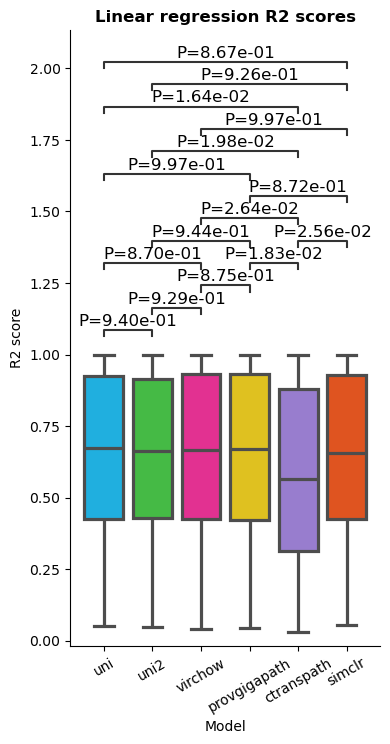

In [8]:
plt.figure(figsize=(4, 8))
plot_boxplot_significance(df_melted, 
                          x='Model', 
                          y='R2 score', 
                          log_scale=False, 
                          stripplot=False, 
                          fontsize=12, 
                          showfliers=False, 
                          stat='t-test', 
                          pairs=None, 
                          p_values=None, 
                          boxplot=True,
                          palette=base_model_palette)

plt.title('Linear regression R2 scores', weight='bold')
#plt.savefig("../Figures/Fig1/hancrafted_features_r2_overall_with_pval.pdf", bbox_inches='tight')

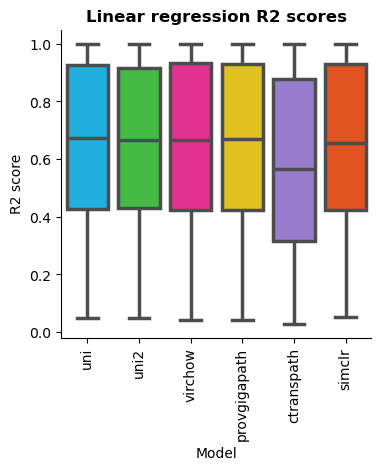

In [9]:
plt.figure(figsize=(4, 4))
sns.boxplot(data=df_melted, x='Model', y='R2 score', showfliers=False, palette=base_model_palette, linewidth=2.5)
sns.despine()
plt.title('Linear regression R2 scores', weight='bold')
plt.xticks(rotation=90)
plt.savefig(os.path.join(config["figures_folder"], "Figure2/handcrafted_features_r2_overall.pdf"), bbox_inches='tight')

In [10]:
with open(os.path.join(config['base_benchmark_folder'], 'shannon_entropy', "shannon_entropy_512_comps_raw_rescaled.json")) as f:
    shannon_entropy = json.load(f)

df_shannon = pd.DataFrame.from_dict(shannon_entropy, orient='index', columns=['shannon_entropy'])

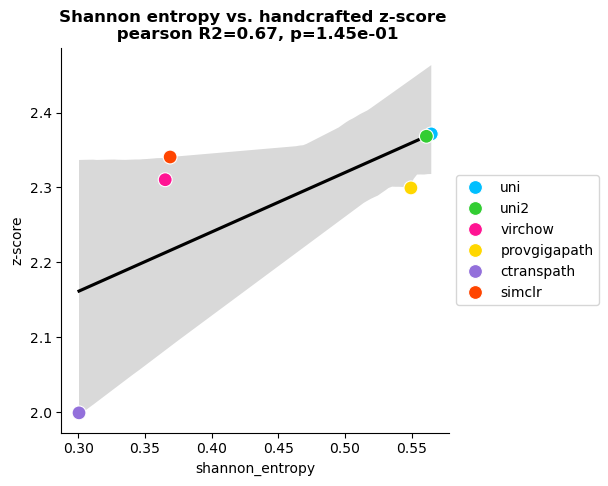

In [11]:
plt.figure(figsize=(5, 5))

df_ = pd.DataFrame(df.mean(numeric_only=True)/df.std(numeric_only=True))
df_.columns = ['z-score']
df_ = df_.merge(df_shannon, left_index=True, right_index=True)

s, p = pearsonr(df_['shannon_entropy'], df_['z-score'])
sns.regplot(x='shannon_entropy', y='z-score', data=df_, color='black')
sns.scatterplot(x='shannon_entropy', y='z-score', data=df_, hue=df_.index, palette=base_model_palette, zorder=2, s=100)
sns.despine()
plt.title(f"Shannon entropy vs. handcrafted z-score \n pearson R2={s:.2f}, p={p:.2e}", weight='bold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(os.path.join(config["figures_folder"], "Figure2/handcrafted_zscore_vs_shannon.pdf"), bbox_inches='tight')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

uni vs. uni2: P=9.30e-01
uni2 vs. virchow: P=5.92e-01
virchow vs. provgigapath: P=8.01e-01
provgigapath vs. ctranspath: P=6.74e-02
ctranspath vs. simclr: P=4.05e-02
uni vs. virchow: P=5.32e-01
uni2 vs. provgigapath: P=7.77e-01
virchow vs. ctranspath: P=1.09e-01
provgigapath vs. simclr: P=8.25e-01
uni vs. provgigapath: P=7.11e-01
uni2 vs. ctranspath: P=3.63e-02
virchow vs. simclr: P=6.34e-01
uni vs. ctranspath: P=2.96e-02
uni2 vs. simclr: P=9.50e-01
uni vs. simclr: P=8.79e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

uni vs. uni2: P=8.97e-01
uni2 vs. virchow: P=9.40e-01
virchow vs. provgigapath: P=9.27e-01
provgigapath vs. ctranspath: P=1.84e-01
ctran

virchow vs. provgigapath: P=9.48e-01
provgigapath vs. ctranspath: P=1.37e-01
ctranspath vs. simclr: P=1.80e-01
uni vs. virchow: P=6.67e-01
uni2 vs. provgigapath: P=5.73e-01
virchow vs. ctranspath: P=1.49e-01
provgigapath vs. simclr: P=7.96e-01
uni vs. provgigapath: P=6.13e-01
uni2 vs. ctranspath: P=2.27e-01
virchow vs. simclr: P=8.51e-01
uni vs. ctranspath: P=2.37e-01
uni2 vs. simclr: P=7.78e-01
uni vs. simclr: P=8.03e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

uni vs. uni2: P=7.47e-01
uni2 vs. virchow: P=9.61e-01
virchow vs. provgigapath: P=8.42e-01
provgigapath vs. ctranspath: P=3.44e-01
ctranspath vs. simclr: P=4.15e-01
uni vs. virchow: P=8.04e-01
uni2 vs. provgigapath: P=8.57e-01
virchow vs. ctranspath: P=4.06e-01
provgigapath vs. simclr: P=8.19e-01
uni vs. provgigapath: P=6.55e-01
uni2 vs. ctranspath: P=3.79e-01
virchow vs. simclr:

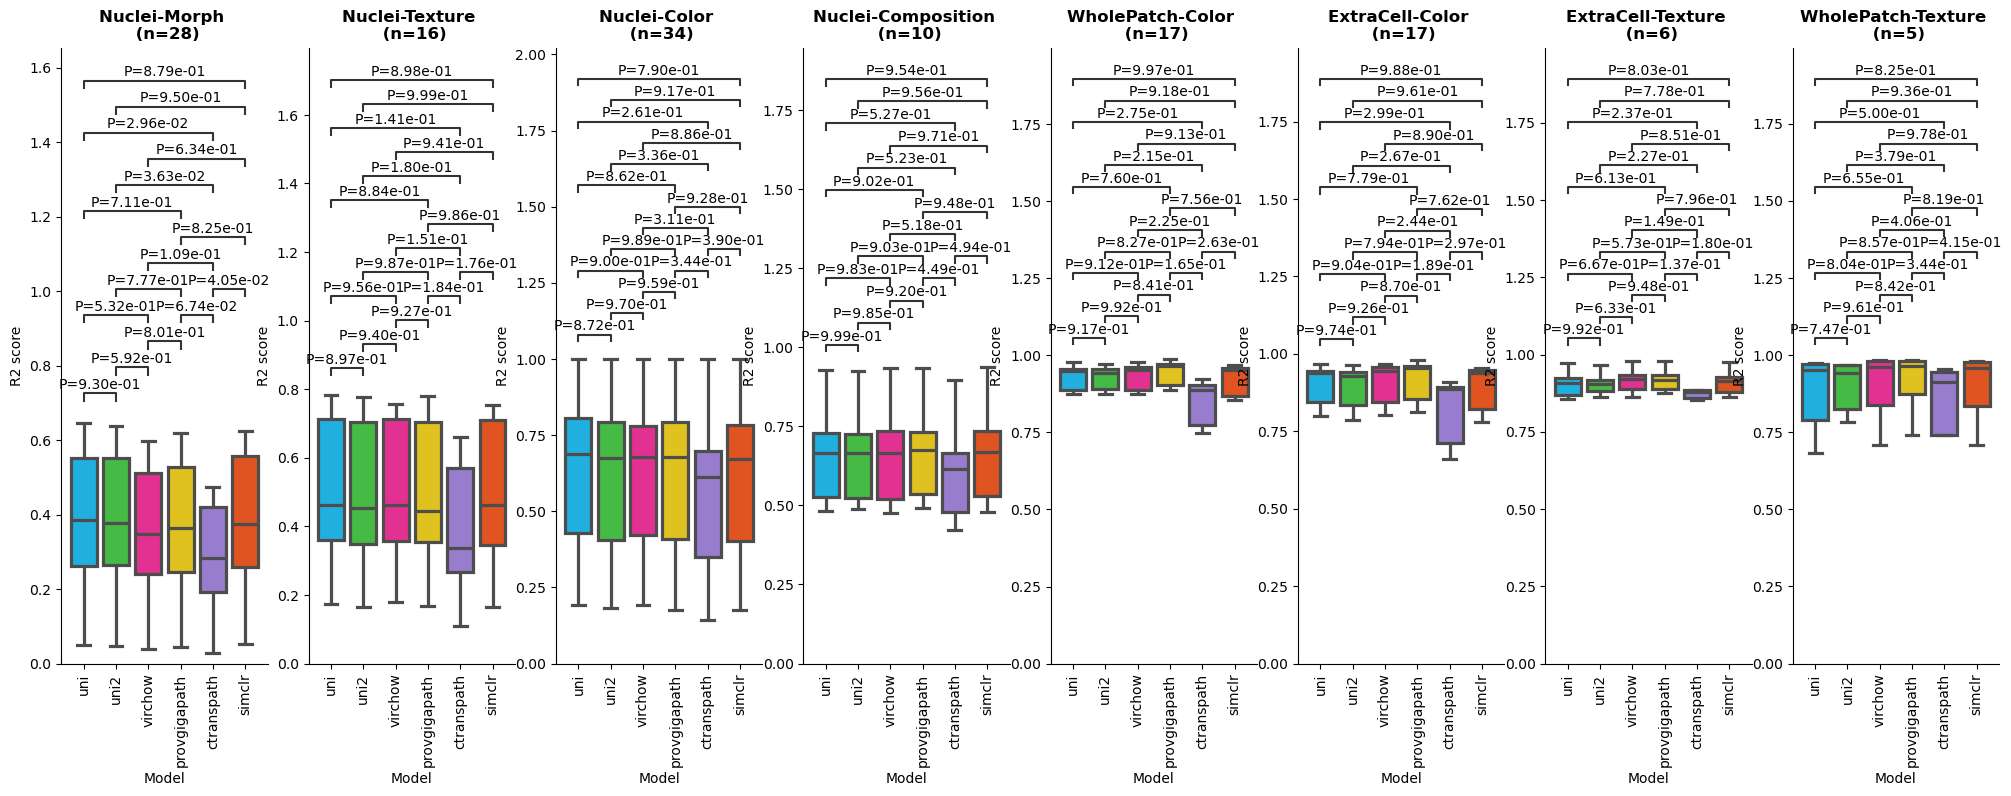

In [12]:
df_melted['feature_type'] = [idx.split("_")[0] for idx in df_melted.index]
plt.figure(figsize=(25, 8))
for feature in df_melted['feature_type'].unique():
    plt.subplot(1, 8, list(df_melted['feature_type'].unique()).index(feature) + 1)
    plot_boxplot_significance(df_melted[df_melted['feature_type'] == feature], 
                              x='Model', 
                              y='R2 score', 
                              log_scale=False, 
                              stripplot=False, 
                              fontsize=10, 
                              showfliers=False, 
                              stat='t-test', 
                              pairs=None, 
                              p_values=None, 
                              boxplot=True,
                              ylim=(0,1),
                              palette=base_model_palette)
    plt.title(f"{feature} \n (n={int(len(df_melted[df_melted['feature_type'] == feature])/len(base_models))})", weight='bold')
    plt.xticks(rotation=90)


In [13]:
df['feature_name'] = df.index   
df[df['feature_name'].str.contains('ExtraCell-Color')]

,uni,uni2,virchow,provgigapath,ctranspath,simclr,feature_type,feature_name
ExtraCell-Color_mean_color_R,0.962773,0.955467,0.964045,0.977762,0.896139,0.952361,ExtraCell-Color,ExtraCell-Color_mean_color_R
ExtraCell-Color_mean_color_G,0.967734,0.962504,0.967906,0.981692,0.890334,0.951726,ExtraCell-Color,ExtraCell-Color_mean_color_G
ExtraCell-Color_mean_color_B,0.950870,0.942983,0.943747,0.971092,0.864596,0.932880,ExtraCell-Color,ExtraCell-Color_mean_color_B
ExtraCell-Color_mean_intensity,0.961652,0.955718,0.960791,0.977813,0.888608,0.947471,ExtraCell-Color,ExtraCell-Color_mean_intensity
ExtraCell-Color_std_color_R,0.937870,0.928073,0.941419,0.949876,0.886714,0.941875,ExtraCell-Color,ExtraCell-Color_std_color_R
ExtraCell-Color_std_color_G,0.941305,0.928743,0.943321,0.955582,0.886150,0.937290,ExtraCell-Color,ExtraCell-Color_std_color_G
ExtraCell-Color_std_color_B,0.939137,0.926395,0.939457,0.949347,0.895285,0.937534,ExtraCell-Color,ExtraCell-Color_std_color_B
ExtraCell-Color_std_intensity,0.941009,0.930309,0.943705,0.953531,0.892144,0.941854,ExtraCell-Color,ExtraCell-Color_std_intensity
ExtraCell-Color_skew_color_R,0.843360,0.835771,0.843399,0.853335,0.713950,0.829682,ExtraCell-Color,ExtraCell-Color_skew_color_R
ExtraCell-Color_skew_color_G,0.846807,0.842422,0.847844,0.861964,0.712376,0.820845,ExtraCell-Color,ExtraCell-Color_skew_color_G


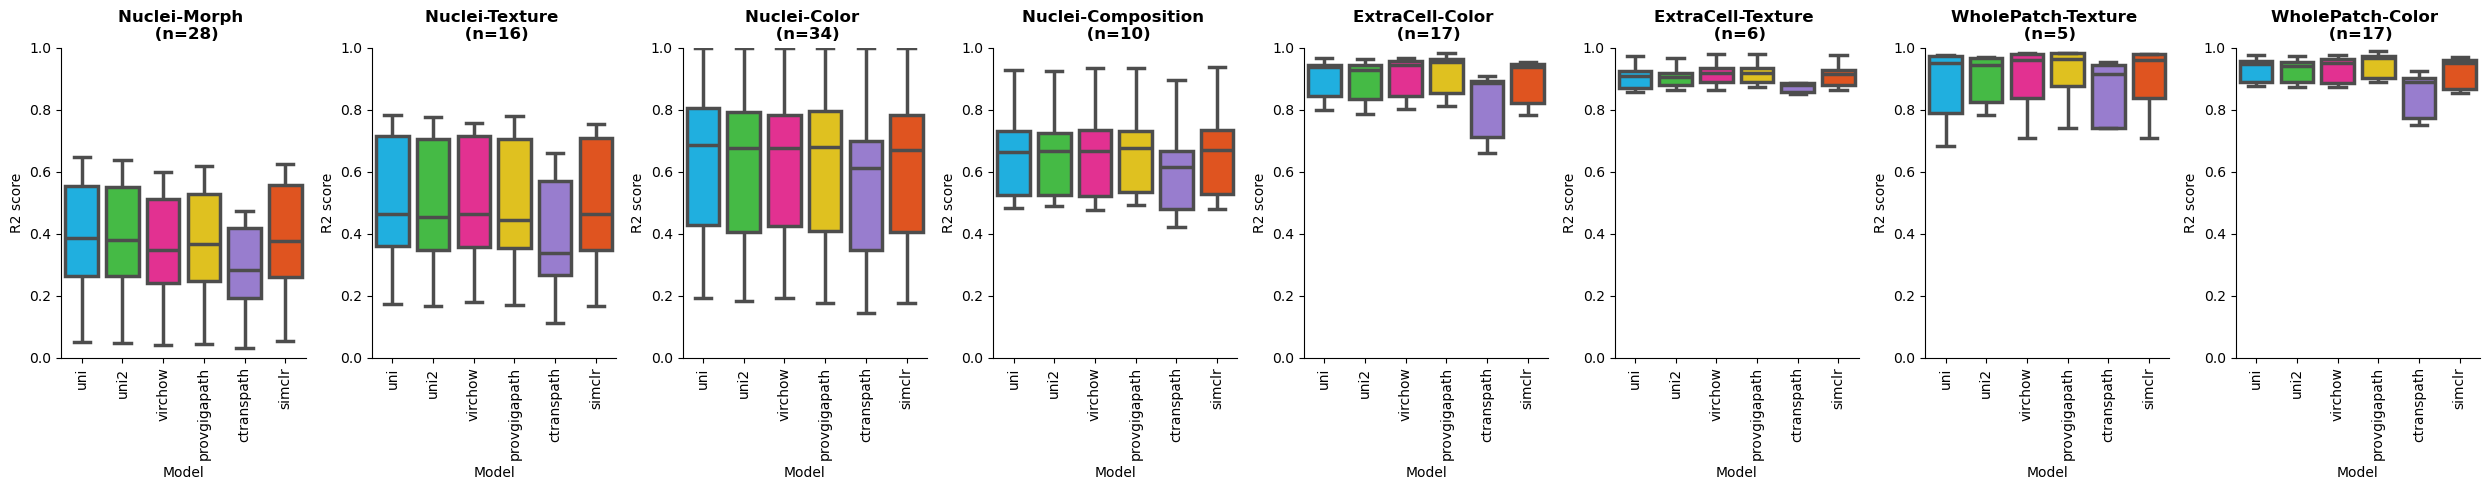

In [14]:
plt.figure(figsize=(25, 5))
ordered_list = ["Nuclei-Morph",
                "Nuclei-Texture",
                "Nuclei-Color",
                "Nuclei-Composition",
                "ExtraCell-Color",
                "ExtraCell-Texture",
                "WholePatch-Texture",
                "WholePatch-Color"]
# for feature in df_melted['feature_type'].unique():
for feature in ordered_list:
    plt.subplot(1, 8, list(ordered_list).index(feature) + 1)

    sns.boxplot(df_melted[df_melted['feature_type'] == feature], 
                              x='Model', 
                              y='R2 score', 
                              showfliers=False, 
                              palette=base_model_palette,
                              linewidth=2.5)
    sns.despine()
    plt.title(f"{feature} \n (n={int(len(df_melted[df_melted['feature_type'] == feature])/len(base_models))})", weight='bold')
    plt.xticks(rotation=90)
    plt.ylim(0, 1)
    
plt.tight_layout()
plt.savefig(os.path.join(config["figures_folder"], "Figure2/handcrafted_features_r2_per_feature.pdf"), bbox_inches='tight')

                                       Model  R2 score  feature_type
Nuclei-Morph_Area_mean                   uni  0.644441  Nuclei-Morph
Nuclei-Morph_AreaBbox_mean               uni  0.607841  Nuclei-Morph
Nuclei-Morph_CellEccentricities_mean     uni  0.553098  Nuclei-Morph
Nuclei-Morph_Circularity_mean            uni  0.554005  Nuclei-Morph
Nuclei-Morph_Elongation_mean             uni  0.602757  Nuclei-Morph
...                                      ...       ...           ...
Nuclei-Morph_Solidity_std             simclr  0.098102  Nuclei-Morph
Nuclei-Morph_CurvMean_std             simclr  0.130308  Nuclei-Morph
Nuclei-Morph_CurvStd_std              simclr  0.092127  Nuclei-Morph
Nuclei-Morph_CurvMax_std              simclr  0.053120  Nuclei-Morph
Nuclei-Morph_CurvMin_std              simclr  0.100533  Nuclei-Morph

[168 rows x 3 columns]
                                    Model  R2 score    feature_type
Nuclei-Texture_ASM_mean               uni  0.372983  Nuclei-Texture
Nuclei-Textu

<Figure size 400x800 with 0 Axes>

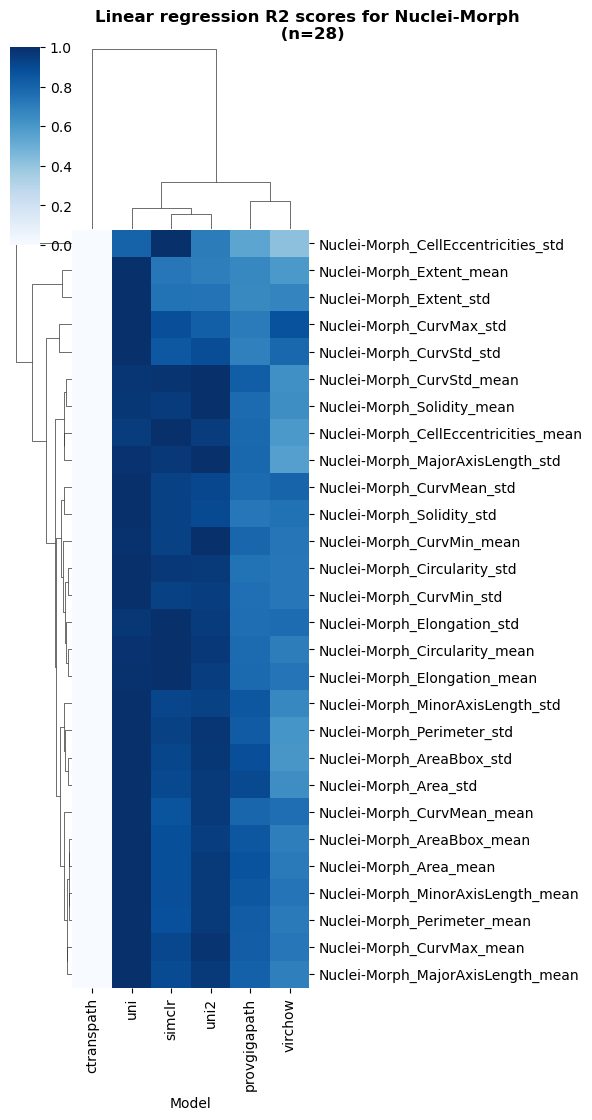

<Figure size 400x800 with 0 Axes>

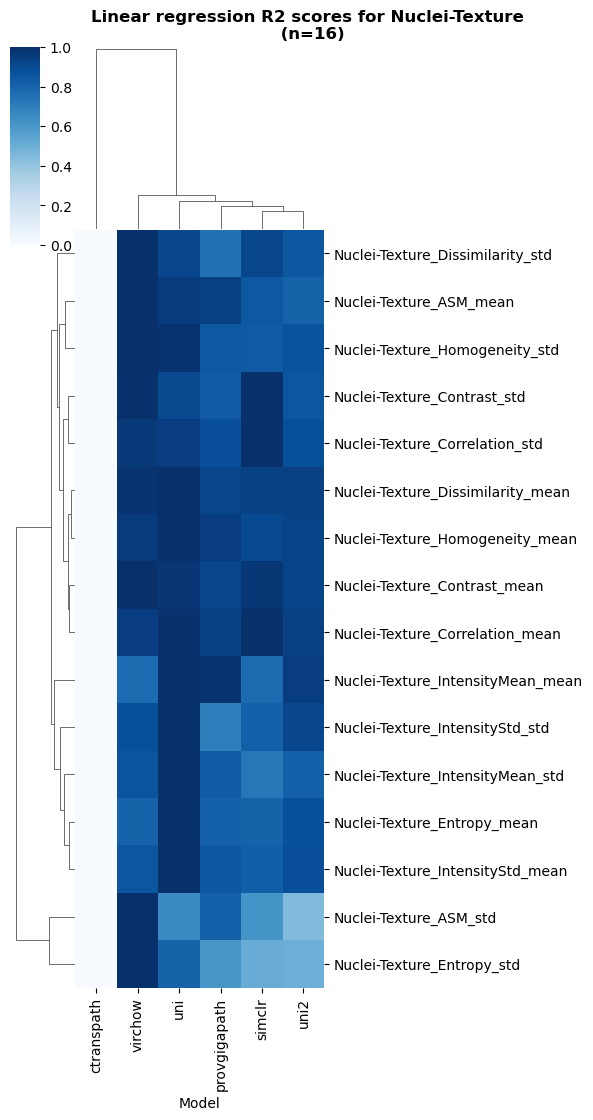

<Figure size 400x800 with 0 Axes>

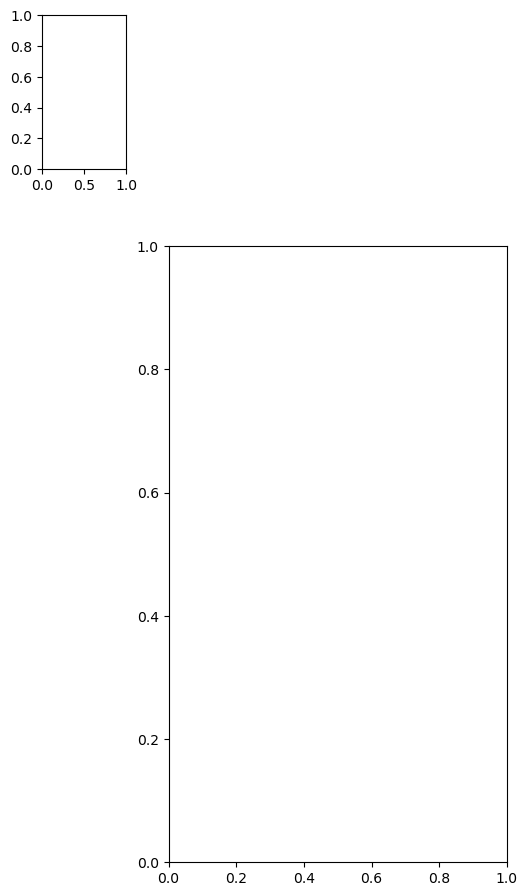

<Figure size 400x800 with 0 Axes>

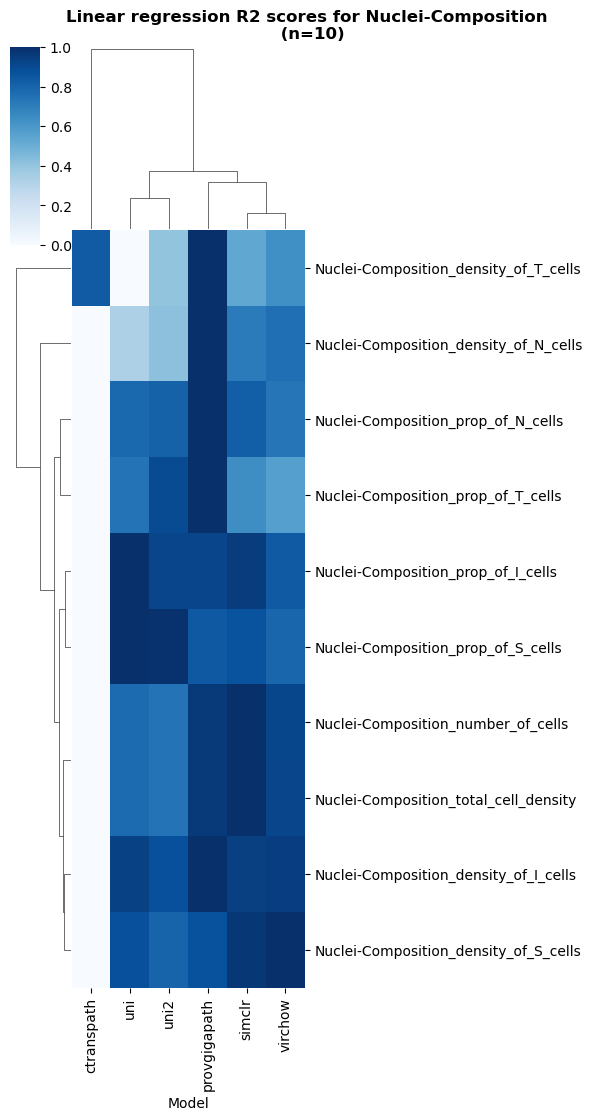

<Figure size 400x800 with 0 Axes>

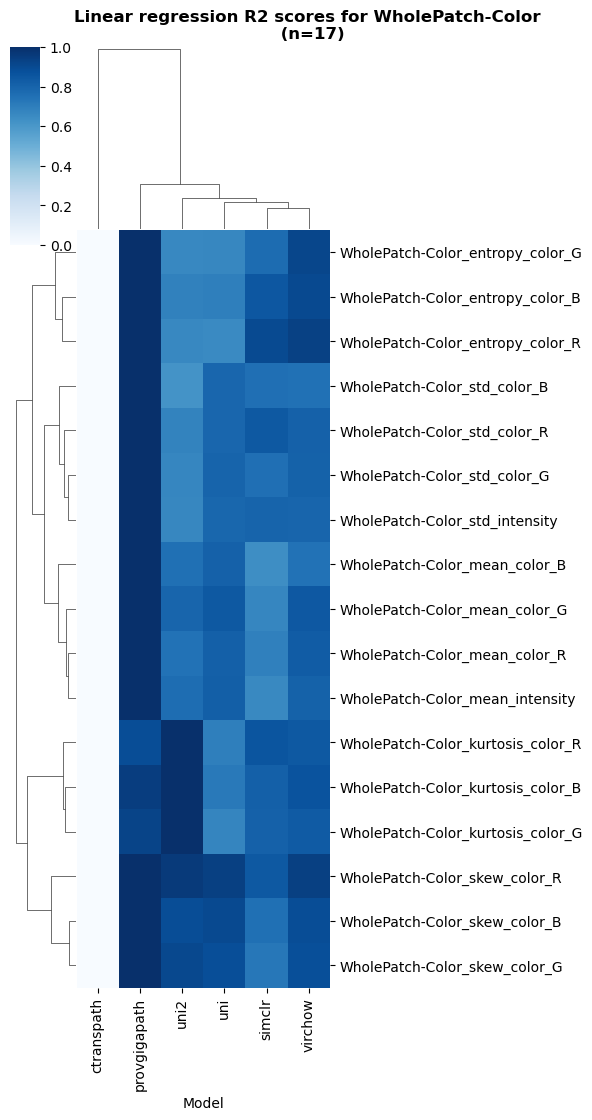

<Figure size 400x800 with 0 Axes>

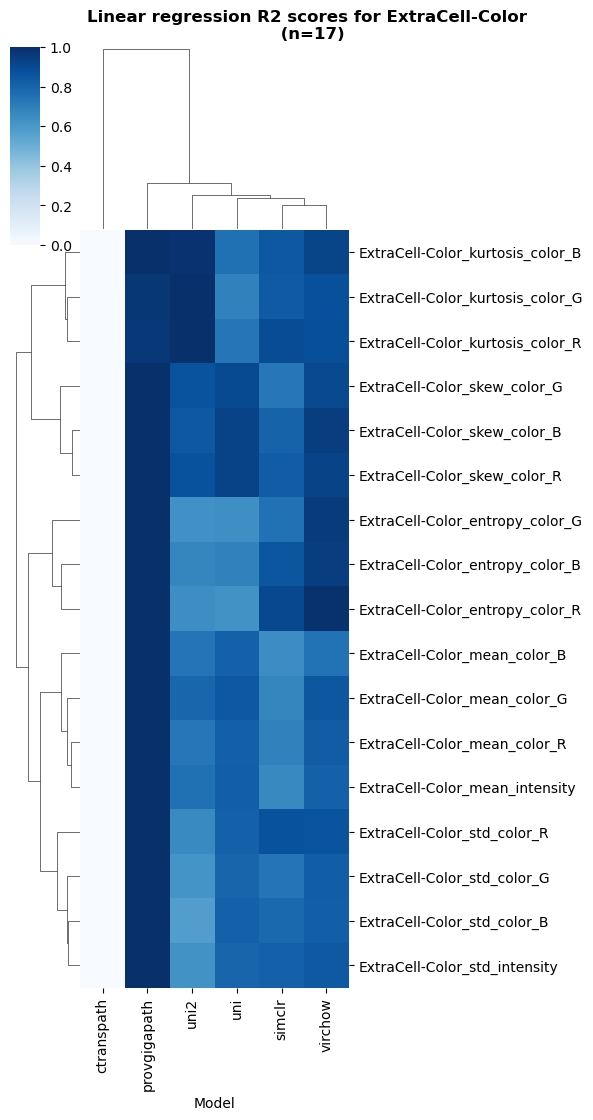

<Figure size 400x800 with 0 Axes>

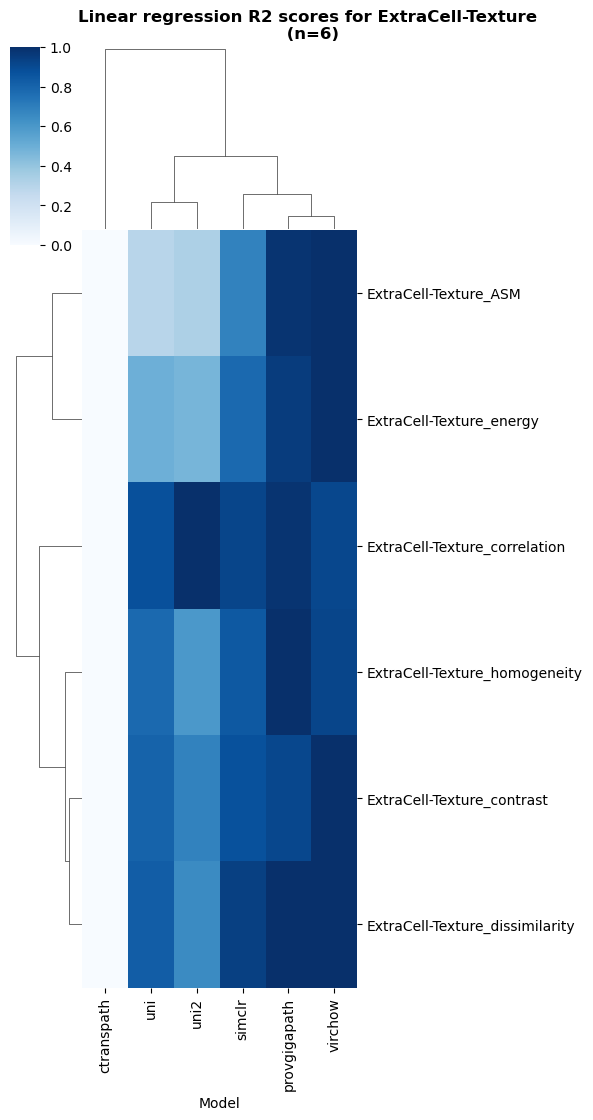

<Figure size 400x800 with 0 Axes>

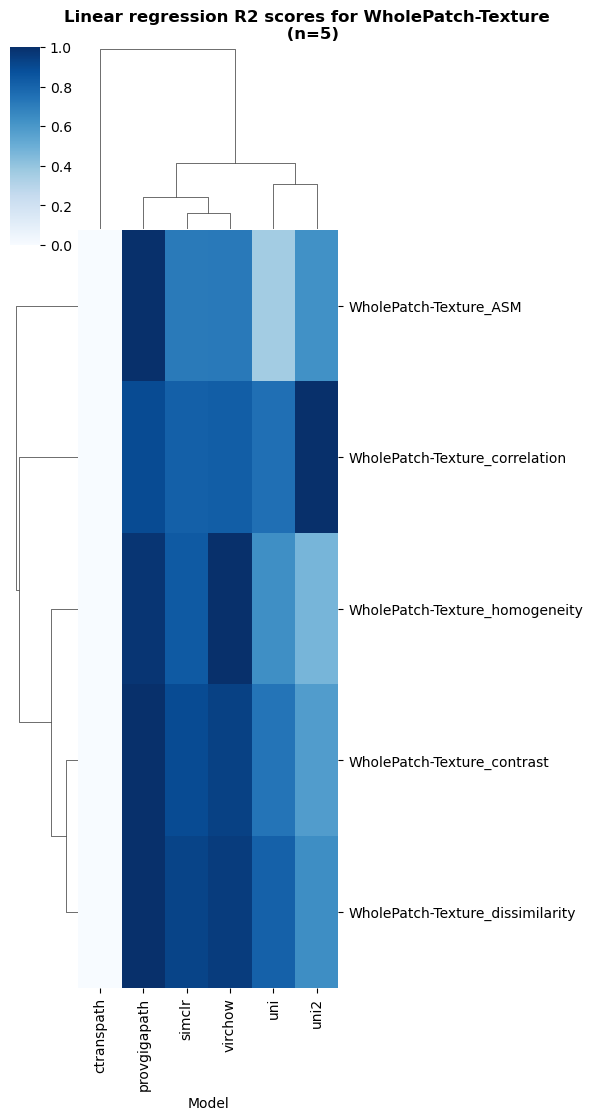

In [15]:
from sklearn.preprocessing import StandardScaler

for feature in df_melted['feature_type'].unique():
    plt.figure(figsize=(4, 8))
    sub_df = df_melted[df_melted['feature_type'] == feature]
    print(sub_df)
    
    # Remove infinite values in the dataframe
    sub_df = sub_df.replace([np.inf, -np.inf], np.nan)
    
    # Drop rows with NaN values
    sub_df = sub_df.dropna()
    
    # Pivot the DataFrame
    pivot_df = sub_df.pivot(columns='Model', values='R2 score')
    
    # Check for non-finite values in the pivoted DataFrame
    if np.any(~np.isfinite(pivot_df.values)):
        print("Pivoted DataFrame contains non-finite values. Replacing them with the maximum finite value.")
        pivot_df = pivot_df.applymap(lambda x: np.nanmax(pivot_df.values[np.isfinite(pivot_df.values)]) if not np.isfinite(x) else x)
    try:
        sns.clustermap(pivot_df, 
                    cmap='Blues', 
                    figsize=(6, 11), 
                    method='average', 
                    metric='euclidean', 
                    standard_scale=0, 
                    row_cluster=True, 
                    col_cluster=True,
                    yticklabels=True)
        plt.title(f"Linear regression R2 scores for {feature} \n (n={int(len(df_melted[df_melted['feature_type'] == feature])/len(base_models))})", weight='bold', x=10)
    except:
        print("Error plotting clustermap")
        continue
    
    plt.savefig(os.path.join(config["figures_folder"], f"Figure2/handcrafted_features_heatmap_r2_{feature}.pdf"), bbox_inches='tight')

                                       Model  R2 score  feature_type
Nuclei-Morph_Area_mean                   uni  0.644441  Nuclei-Morph
Nuclei-Morph_AreaBbox_mean               uni  0.607841  Nuclei-Morph
Nuclei-Morph_CellEccentricities_mean     uni  0.553098  Nuclei-Morph
Nuclei-Morph_Circularity_mean            uni  0.554005  Nuclei-Morph
Nuclei-Morph_Elongation_mean             uni  0.602757  Nuclei-Morph
...                                      ...       ...           ...
Nuclei-Morph_Solidity_std             simclr  0.098102  Nuclei-Morph
Nuclei-Morph_CurvMean_std             simclr  0.130308  Nuclei-Morph
Nuclei-Morph_CurvStd_std              simclr  0.092127  Nuclei-Morph
Nuclei-Morph_CurvMax_std              simclr  0.053120  Nuclei-Morph
Nuclei-Morph_CurvMin_std              simclr  0.100533  Nuclei-Morph

[168 rows x 3 columns]
                                    Model  R2 score    feature_type
Nuclei-Texture_ASM_mean               uni  0.372983  Nuclei-Texture
Nuclei-Textu

<Figure size 400x800 with 0 Axes>

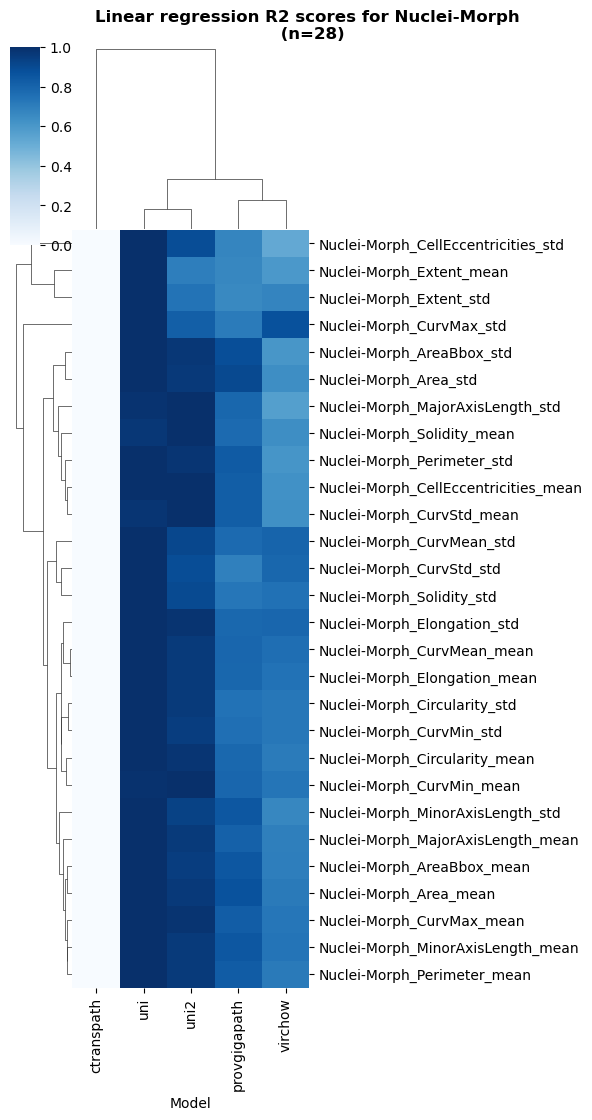

<Figure size 400x800 with 0 Axes>

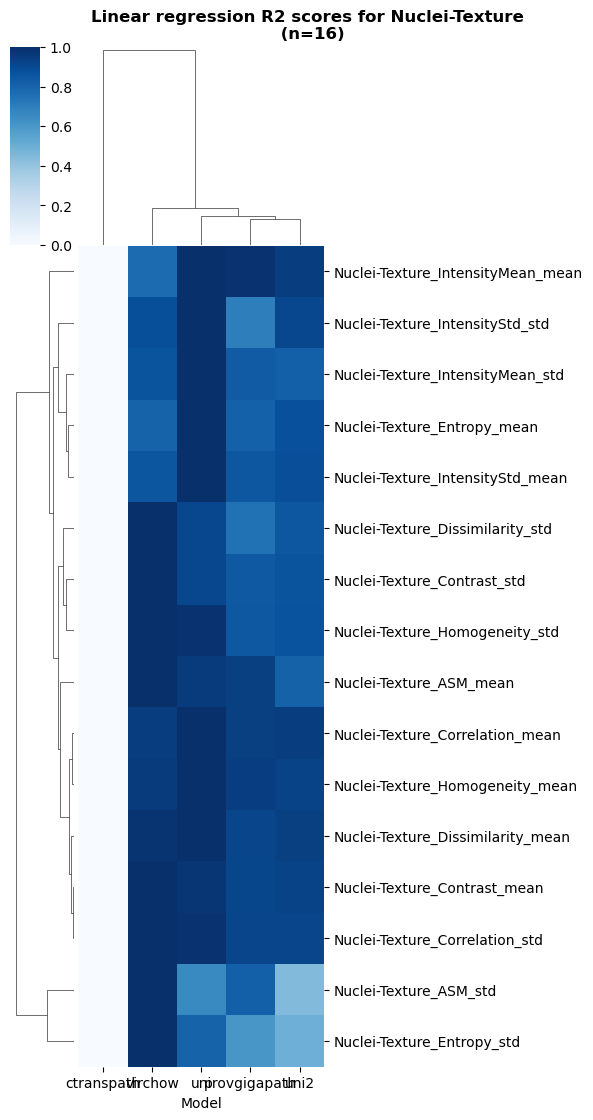

<Figure size 400x800 with 0 Axes>

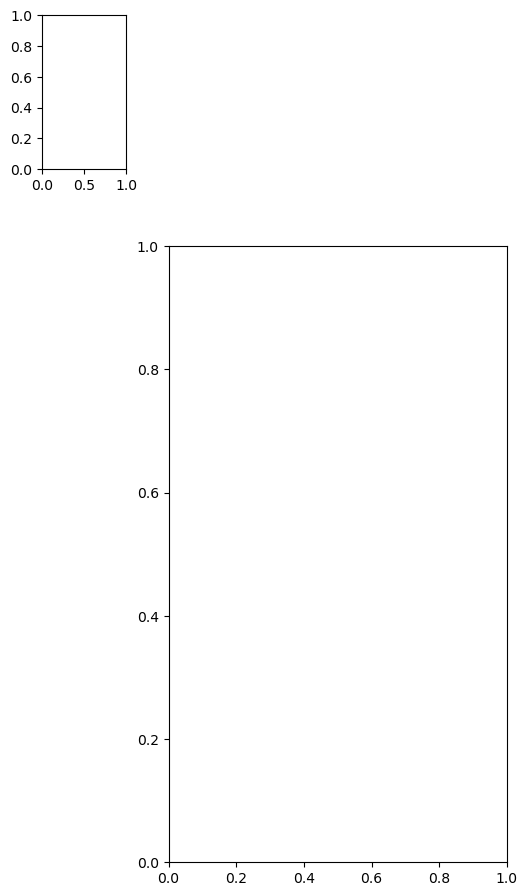

<Figure size 400x800 with 0 Axes>

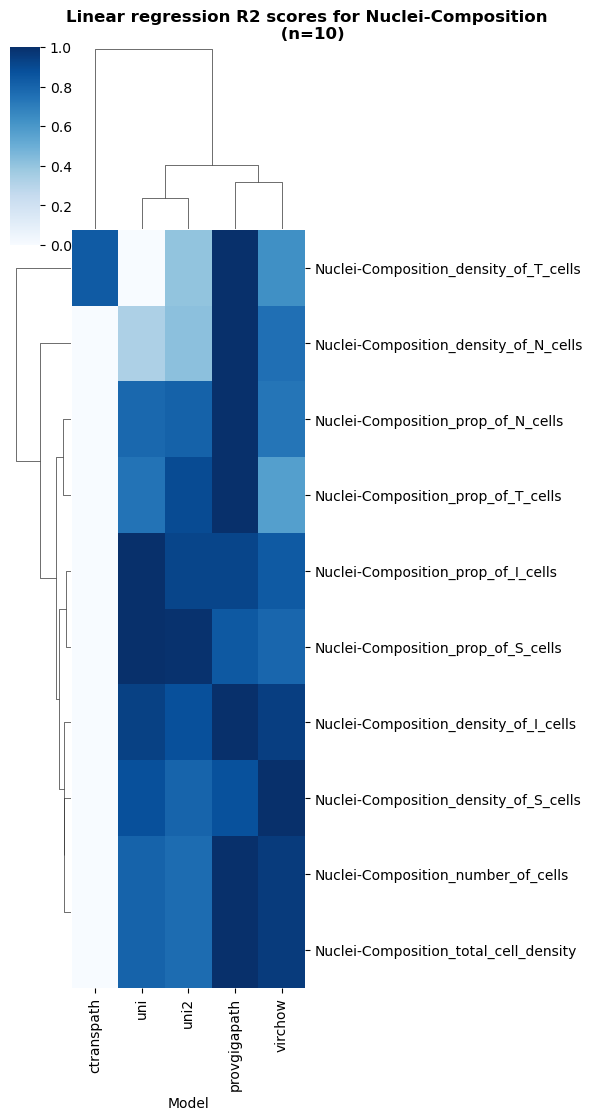

<Figure size 400x800 with 0 Axes>

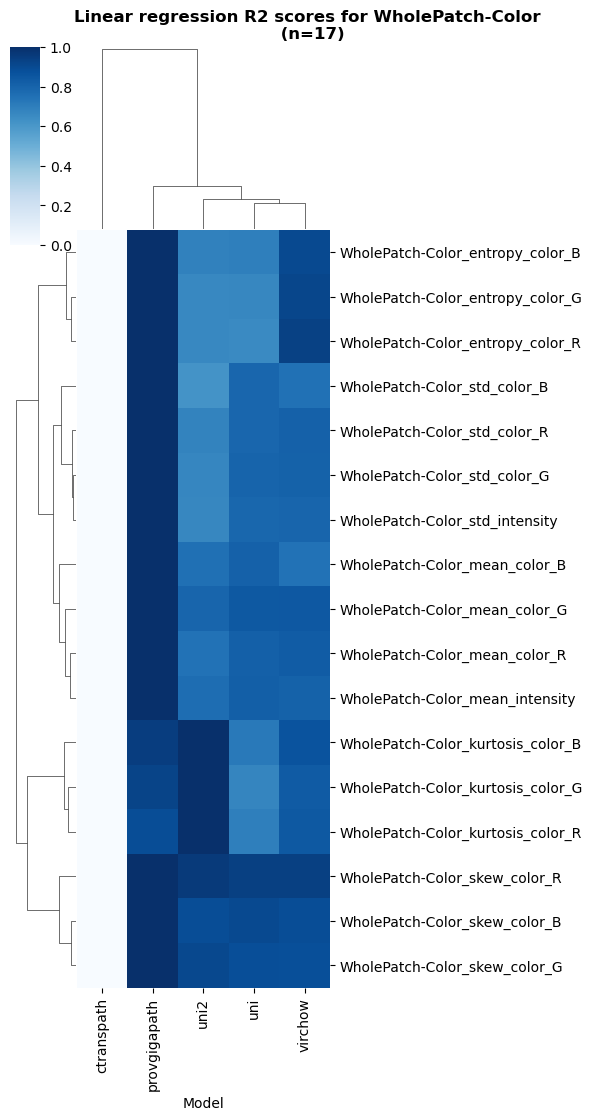

<Figure size 400x800 with 0 Axes>

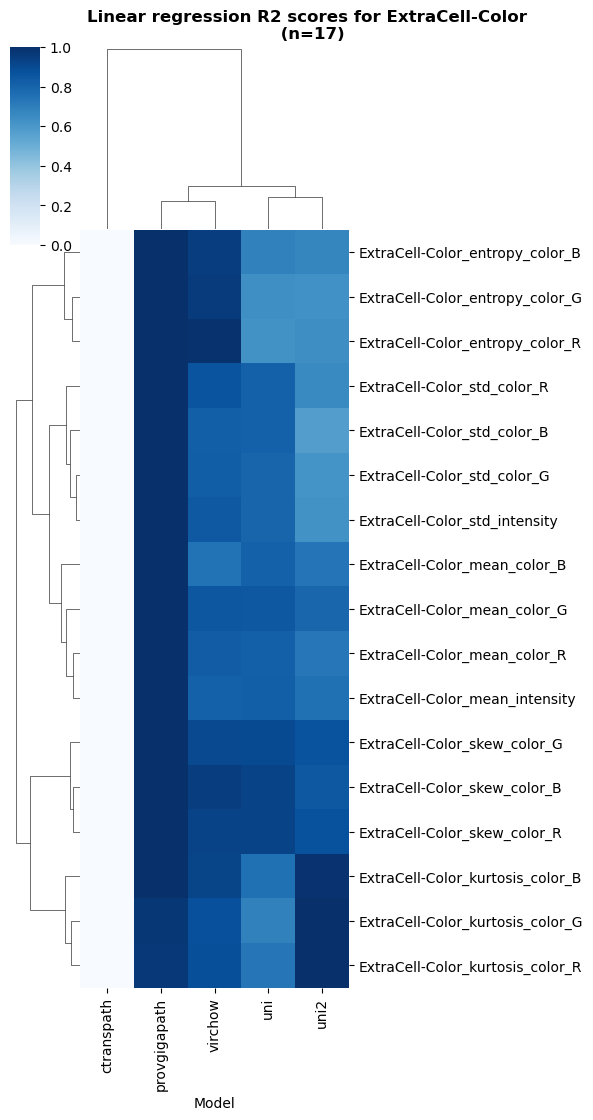

<Figure size 400x800 with 0 Axes>

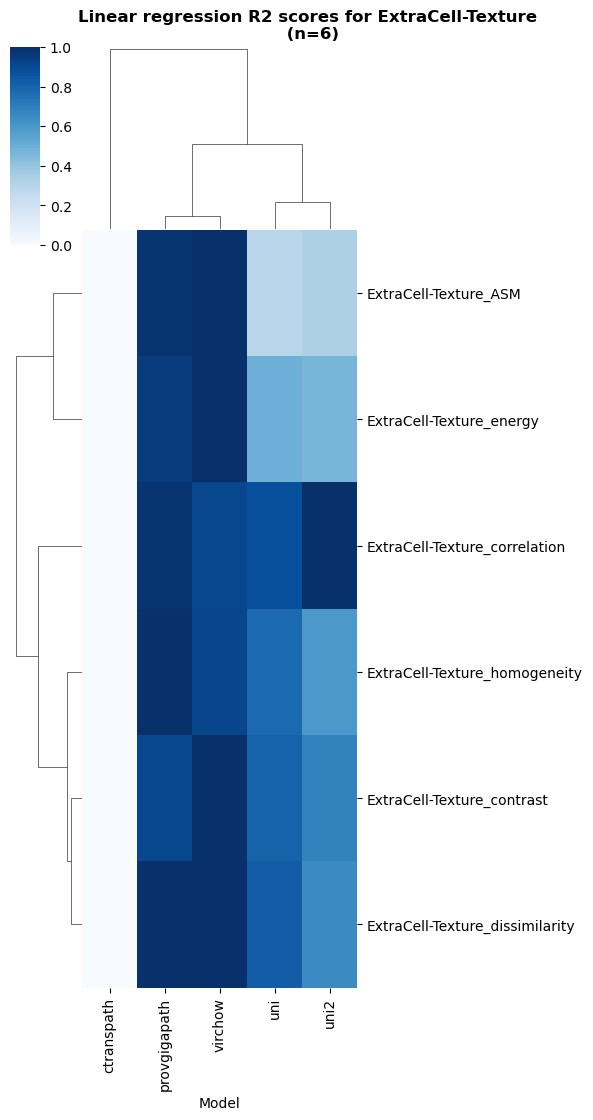

<Figure size 400x800 with 0 Axes>

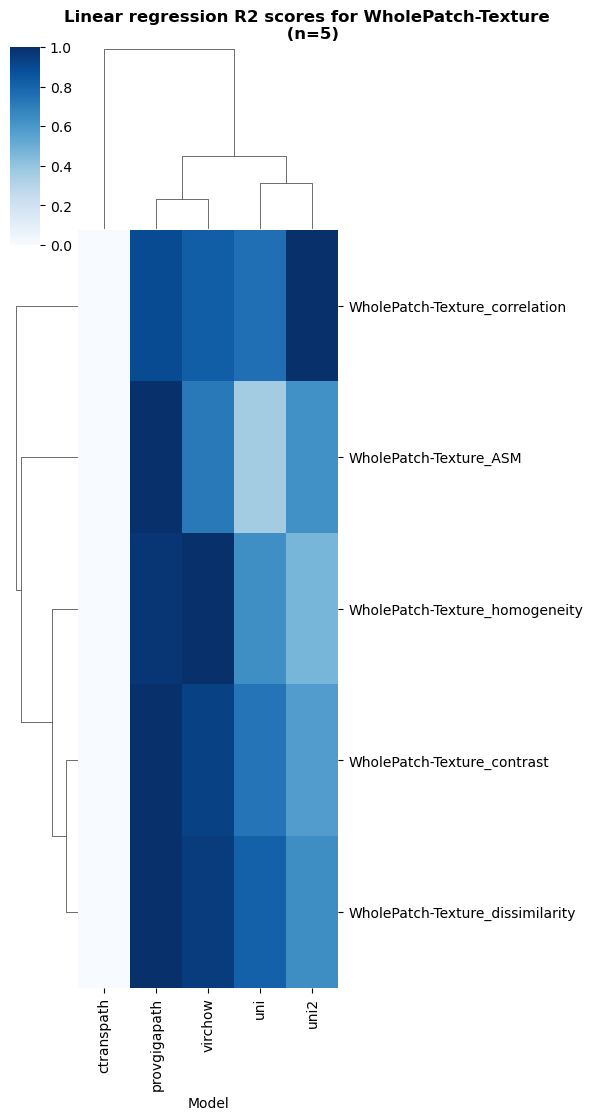

In [16]:
for feature in df_melted['feature_type'].unique():
    plt.figure(figsize=(4, 8))
    sub_df = df_melted[df_melted['feature_type'] == feature]
    print(sub_df)
    
    # Remove infinite values in the dataframe
    sub_df = sub_df.replace([np.inf, -np.inf], np.nan)
    
    # Drop rows with NaN values
    sub_df = sub_df.dropna()
    
    # Pivot the DataFrame
    pivot_df = sub_df.pivot(columns='Model', values='R2 score')
    
    pivot_df.drop(['simclr'], axis=1, inplace=True)
    # Check for non-finite values in the pivoted DataFrame
    if np.any(~np.isfinite(pivot_df.values)):
        print("Pivoted DataFrame contains non-finite values. Replacing them with the maximum finite value.")
        pivot_df = pivot_df.applymap(lambda x: np.nanmax(pivot_df.values[np.isfinite(pivot_df.values)]) if not np.isfinite(x) else x)

    try:
        sns.clustermap(pivot_df, 
                    cmap='Blues', 
                    figsize=(6, 11), 
                    method='average', 
                    metric='euclidean', 
                    standard_scale=0, 
                    row_cluster=True, 
                    col_cluster=True,
                    yticklabels=True)
        plt.title(f"Linear regression R2 scores for {feature} \n (n={int(len(df_melted[df_melted['feature_type'] == feature])/len(base_models))})", weight='bold', x=10)
    except:
        print("Error plotting clustermap")
        continue
    
    plt.savefig(os.path.join(config["figures_folder"], f"Figure3/handcrafted_features_heatmap_r2_{feature}_without_simclr.pdf"), bbox_inches='tight')

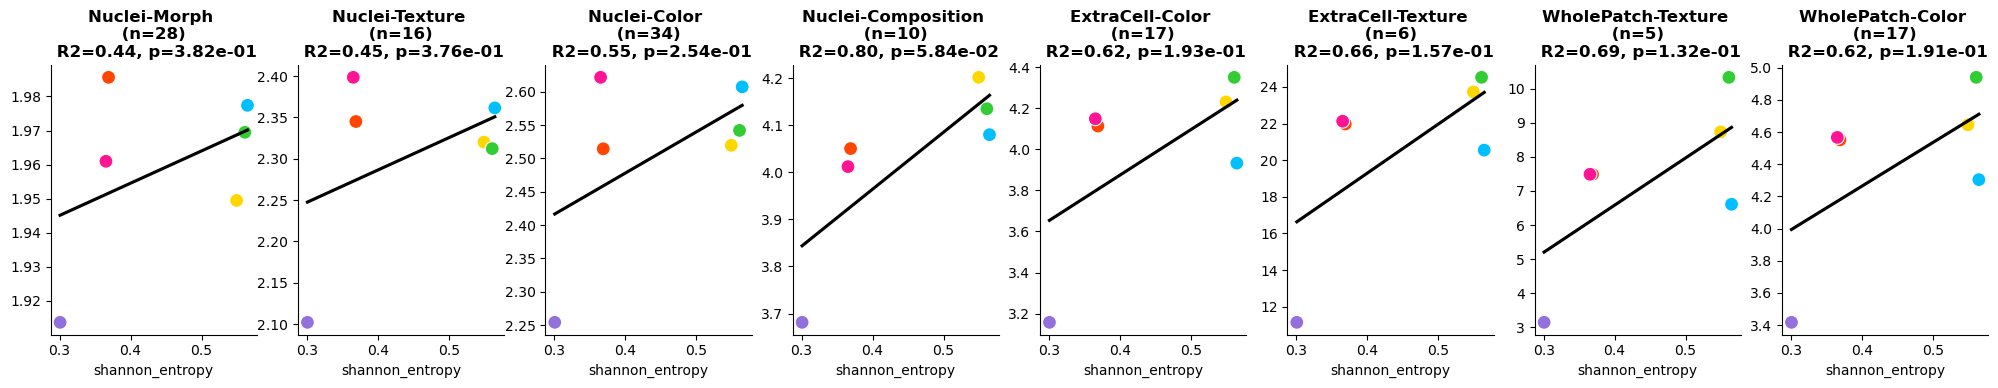

In [17]:
base_model_palette = config["base_model_palette"]
plt.figure(figsize=(25, 3.5))

for feature in ordered_list:
    plt.subplot(1, 8, ordered_list.index(feature) + 1)
    sub_df = df_melted[df_melted['feature_type'] == feature].pivot(columns='Model', values='R2 score')
    df_ = pd.DataFrame(sub_df.mean()/sub_df.std())
    df_.columns = ['z-score']
    df_ = df_.merge(df_shannon, left_index=True, right_index=True)

    s, p = pearsonr(df_['shannon_entropy'], df_['z-score'])

    sns.regplot(x='shannon_entropy', y='z-score', data=df_, color='black', ci=None)
    sns.scatterplot(x='shannon_entropy', y='z-score', data=df_, 
                    hue=df_.index, palette=base_model_palette, s=100)
    sns.despine()
    plt.title(f"{feature} \n (n={int(len(df_melted[df_melted['feature_type'] == feature])/len(base_models))}) \n R2={s:.2f}, p={p:.2e}", weight='bold')
    if list(df_melted['feature_type'].unique()).index(feature) + 1 != 8:
        plt.legend().remove()
    else:
        plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1.1))
        plt.legend().remove()

    plt.ylabel('')
        
plt.savefig(os.path.join(config["figures_folder"], "Figure2/handcrafted_zscore_vs_shannon_per_feature.pdf"), bbox_inches='tight')

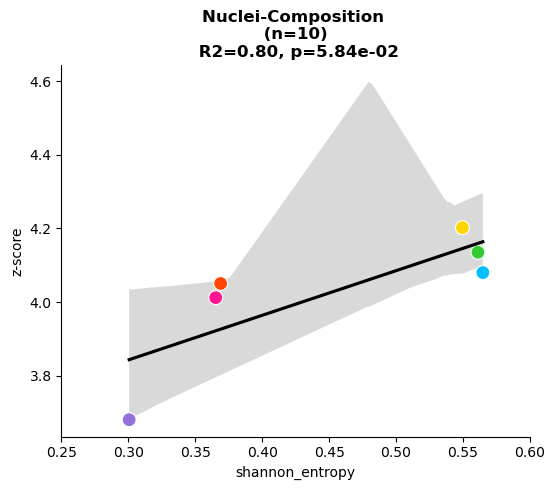

In [18]:
plt.figure(figsize=(5.5,5))
feature="Nuclei-Composition"
sub_df = df_melted[df_melted['feature_type'] == feature].pivot(columns='Model', values='R2 score')
df_ = pd.DataFrame(sub_df.mean()/sub_df.std())
df_.columns = ['z-score']
df_ = df_.merge(df_shannon, left_index=True, right_index=True)

s, p = pearsonr(df_['shannon_entropy'], df_['z-score'])

sns.regplot(x='shannon_entropy', y='z-score', data=df_, color='black')
sns.scatterplot(x='shannon_entropy', y='z-score', data=df_, hue=df_.index, palette=base_model_palette, s=100)
sns.despine()
plt.title(f"{feature} \n (n={int(len(df_melted[df_melted['feature_type'] == feature])/len(base_models))}) \n R2={s:.2f}, p={p:.2e}", weight='bold')
if list(df_melted['feature_type'].unique()).index(feature) + 1 != 8:
    plt.legend().remove()
else:
    plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1.1))
        
plt.tight_layout()
plt.xlim(0.25,0.6)
plt.savefig(os.path.join(config["figures_folder"], "Figure2/handcrafted_zscore_vs_shannon_per_feature.pdf"), bbox_inches='tight')

## Retrained models

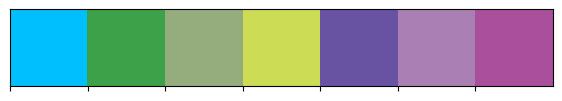

In [19]:
retrained_palette = sns.color_palette(config['retrained_color_palette'])
sns.palplot(retrained_palette)

# Create the results folder
os.makedirs(os.path.join(config["figures_folder"], "Figure3"), exist_ok=True)

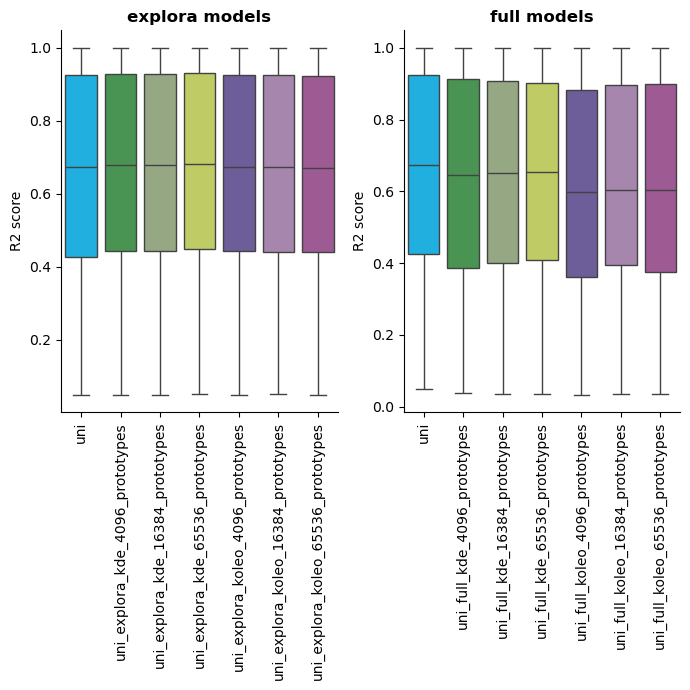

In [20]:
plt.figure(figsize=(7, 7))

i = 0
for model_type, names, benchmark_folder in zip(
    [config['retrained_model_list1_type'], config['retrained_model_list2_type']], 
    [config['retrained_model_list1'], config['retrained_model_list2']],
    [config['retrained_benchmark_folder1'], config['retrained_benchmark_folder2']]):

    dfs = []
    for model_name in names:
        dfs.append(pd.read_csv(os.path.join(benchmark_folder, "regression/linear", model_name, 'r2_scores.csv'), index_col=0))

    df = pd.concat(dfs, axis=1)
    df.columns = names

    plt.subplot(1, 2, i+1)
    sns.boxplot(data=df, palette=retrained_palette, showfliers=False)
    sns.despine()
    plt.xticks(rotation=90);
    plt.title(f"{model_type} models", weight='bold')
    plt.ylabel("R2 score")
    i += 1

plt.tight_layout()    
plt.savefig(os.path.join(config['figures_folder'], "Figure3/handcrafted_features_r2_boxplots.pdf"), bbox_inches='tight')

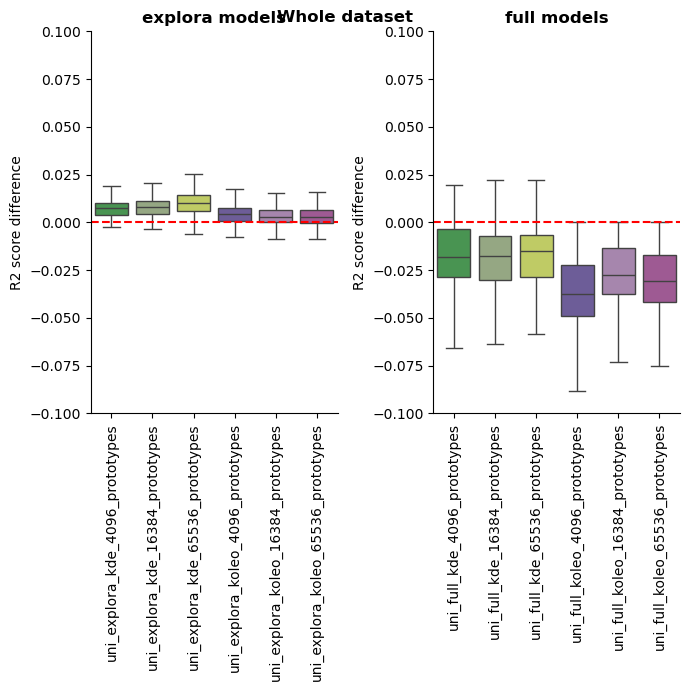

In [21]:
plt.figure(figsize=(7, 7))

i = 0
for model_type, names, benchmark_folder in zip(
    [config['retrained_model_list1_type'], config['retrained_model_list2_type']], 
    [config['retrained_model_list1'], config['retrained_model_list2']],
    [config['retrained_benchmark_folder1'], config['retrained_benchmark_folder2']]):

    dfs = []
    
    for model_name in names:
        dfs.append(pd.read_csv(os.path.join(benchmark_folder, "regression", "linear", model_name, 'r2_scores.csv'), index_col=0))

    df = pd.concat(dfs, axis=1)
    df.columns = names
    df_diff = df.apply(lambda x: x - df['uni'], axis=0)
    df_diff.drop('uni', axis=1, inplace=True)

    plt.subplot(1, 2, i+1)
    sns.boxplot(data=df_diff, palette=retrained_palette[1:], showfliers=False)
    sns.despine()
    plt.xticks(rotation=90);
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"{model_type} models", weight='bold')
    plt.ylim(-0.1, 0.1)
    plt.ylabel("R2 score difference")
    i += 1

plt.tight_layout()
plt.suptitle("Whole dataset", weight='bold')
plt.savefig(os.path.join(config['figures_folder'], "Figure3/handcrafted_features_r2_diff_boxplots.pdf"), bbox_inches='tight')

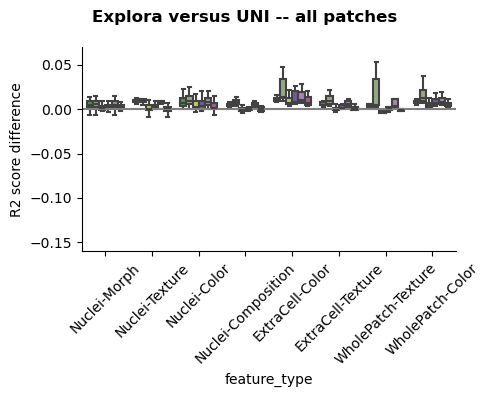

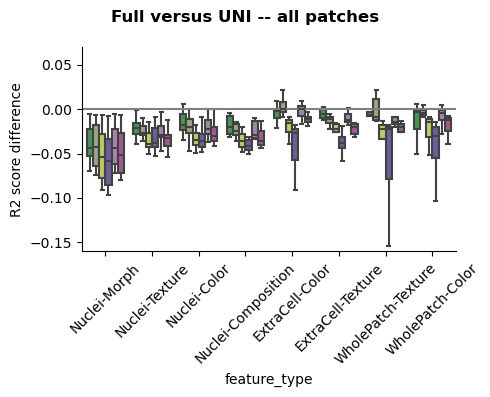

In [22]:
for model_type, names, benchmark_folder in zip(
    [config['retrained_model_list1_type'], config['retrained_model_list2_type']], 
    [config['retrained_model_list1'], config['retrained_model_list2']],
    [config['retrained_benchmark_folder1'], config['retrained_benchmark_folder2']]):

    dfs = []
    for model_name in names:
        dfs.append(pd.read_csv(os.path.join(benchmark_folder, "regression", "linear", model_name, 'r2_scores.csv'), index_col=0))

    df = pd.concat(dfs, axis=1)
    df.columns = names
    df_diff = df.apply(lambda x: x - df['uni'], axis=0)
    df_diff.drop('uni', axis=1, inplace=True)
    df_diff_melted = df_diff.reset_index().melt(id_vars='index', var_name='Model', value_name='R2 score difference')
    df_diff_melted.rename(columns={'index': 'feature'}, inplace=True)
    df_diff_melted["feature_type"] = [idx.split("_")[0] for idx in df_diff_melted['feature']]

    # Enforce the desired order for feature_type and sort the dataframe accordingly
    df_diff_melted['feature_type'] = pd.Categorical(
      df_diff_melted['feature_type'], categories=ordered_list, ordered=True)
    df_diff_melted = df_diff_melted.sort_values('feature_type').reset_index(drop=True)
    
    plt.figure(figsize=(5, 4))
    sns.boxplot(df_diff_melted, x='feature_type', y='R2 score difference', hue="Model", showfliers=False, palette=retrained_palette[1:], linewidth=1.5)
    sns.despine()
    plt.ylim(-0.16, 0.07)
    plt.legend().remove()
    plt.xticks(rotation=45);
    plt.axhline(y=0, color="gray")
    plt.suptitle(f"{model_type.capitalize()} versus UNI -- all patches", weight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(config["figures_folder"], f"Figure3/handcrafted_features_r2_diff_{model_type}_vs_uni_per_feature.pdf"), bbox_inches='tight')

## Retrained models -- on invasive cancer only

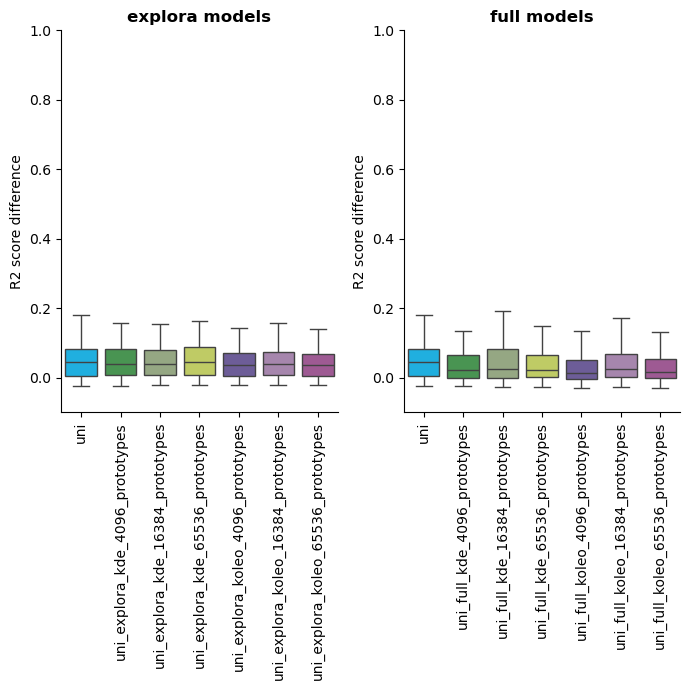

In [23]:
plt.figure(figsize=(7, 7))

i = 0
for model_type, names, benchmark_folder in zip(
    [config['retrained_model_list1_type'], config['retrained_model_list2_type']], 
    [config['retrained_model_list1'], config['retrained_model_list2']],
    [config['retrained_benchmark_folder1'], config['retrained_benchmark_folder2']]):

    dfs = []
    
    for model_name in names:
        dfs.append(pd.read_csv(os.path.join(benchmark_folder, "regression", "linear", "invasive", model_name, 'r2_scores.csv'), index_col=0))
    
    df = pd.concat(dfs, axis=1)
    df.columns = names

    plt.subplot(1, 2, i+1)
    sns.boxplot(data=df, palette=retrained_palette, showfliers=False)
    sns.despine()
    plt.xticks(rotation=90);
    plt.title(f"{model_type} models", weight='bold')
    plt.ylabel("R2 score difference")
    plt.ylim(-0.1, 1)
    i += 1

plt.tight_layout()
plt.savefig(os.path.join(config["figures_folder"], "Figure3/handcrafted_features_r2_boxplots_invasive.pdf"), bbox_inches='tight')

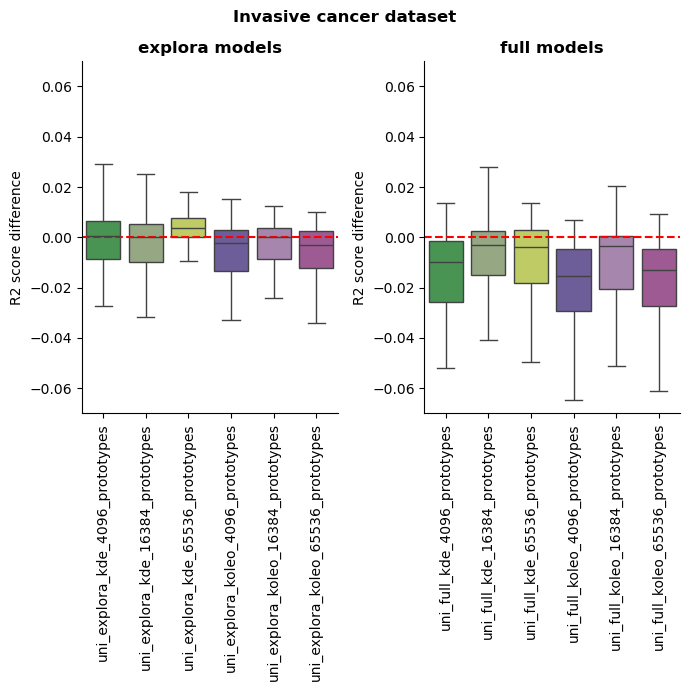

In [24]:
plt.figure(figsize=(7, 7))

i = 0
for model_type, names, benchmark_folder in zip(
    [config['retrained_model_list1_type'], config['retrained_model_list2_type']], 
    [config['retrained_model_list1'], config['retrained_model_list2']],
    [config['retrained_benchmark_folder1'], config['retrained_benchmark_folder2']]):

    dfs = []
    
    for model_name in names:
        dfs.append(pd.read_csv(os.path.join(benchmark_folder, "regression", "linear", "invasive", model_name, 'r2_scores.csv'), index_col=0))
    
    df = pd.concat(dfs, axis=1)
    df.columns = names
    df_diff = df.apply(lambda x: x - df['uni'], axis=0)
    df_diff.drop('uni', axis=1, inplace=True)

    plt.subplot(1, 2, i+1)
    sns.boxplot(data=df_diff, palette=retrained_palette[1:], showfliers=False)
    sns.despine()
    plt.xticks(rotation=90);
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"{model_type} models", weight='bold')
    plt.ylim(-0.07, 0.07)
    plt.ylabel("R2 score difference")
    i += 1

plt.suptitle("Invasive cancer dataset", weight='bold')
plt.tight_layout()
plt.savefig(os.path.join(config["figures_folder"], "Figure3/handcrafted_features_r2_diff_boxplots_invasive.pdf"), bbox_inches='tight')

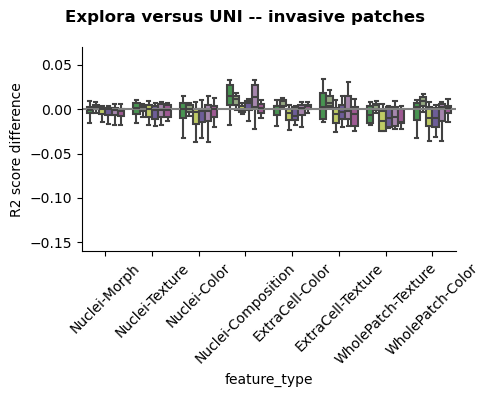

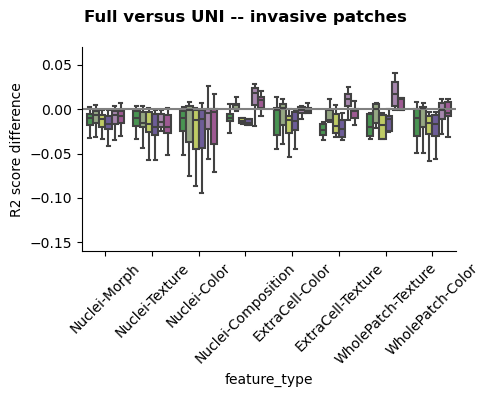

In [25]:
for model_type, names, benchmark_folder in zip(
    [config['retrained_model_list1_type'], config['retrained_model_list2_type']], 
    [config['retrained_model_list1'], config['retrained_model_list2']],
    [config['retrained_benchmark_folder1'], config['retrained_benchmark_folder2']]):
    
    dfs = []

    for model_name in names:
        dfs.append(pd.read_csv(os.path.join(benchmark_folder, "regression", "linear", "invasive", model_name, 'r2_scores.csv'), index_col=0))
    
    df = pd.concat(dfs, axis=1)
    df.columns = names
    df_diff = df.apply(lambda x: x - df['uni'], axis=0)
    df_diff.drop('uni', axis=1, inplace=True)
    df_diff_melted = df_diff.reset_index().melt(id_vars='index', var_name='Model', value_name='R2 score difference')
    df_diff_melted.rename(columns={'index': 'feature'}, inplace=True)
    df_diff_melted["feature_type"] = [idx.split("_")[0] for idx in df_diff_melted['feature']]

    # Enforce the desired order for feature_type and sort the dataframe accordingly
    df_diff_melted['feature_type'] = pd.Categorical(
        df_diff_melted['feature_type'], categories=ordered_list, ordered=True)
    df_diff_melted = df_diff_melted.sort_values('feature_type').reset_index(drop=True)
    
    plt.figure(figsize=(5, 4))
    sns.boxplot(df_diff_melted, x='feature_type', y='R2 score difference', hue="Model", showfliers=False, palette=retrained_palette[1:], linewidth=1.5)
    sns.despine()
    plt.ylim(-0.16, 0.07)
    plt.legend().remove()
    plt.xticks(rotation=45);
    plt.axhline(y=0, color="gray")
    plt.suptitle(f"{model_type.capitalize()} versus UNI -- invasive patches", weight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(config["figures_folder"], f"Figure3/handcrafted_features_r2_diff_{model_type}_vs_uni_per_feature_invasive_only.pdf"), bbox_inches='tight')